In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias.html

In [2]:
filename = 'covid19-es-and.csv'
fecha = '14/06/2020'
id_noticia = '237901'
url = 'https://www.juntadeandalucia.es/organismos/saludyfamilias/actualidad/noticias/detalle/' + id_noticia + '.html'

In [3]:
# Load
tables = pd.read_html(url, header=0, thousands='.')
assert len(tables) > 0
dfL = tables[0]

In [4]:
# Prepare
dfL['Fecha'] = fecha
# A partir del 14/05/2020 se cambia el formato del dato añadiendo en la misma columna el número de nuevos casos
for col in ['PCR Positivo',	'Hospitalización', 'UCI', 'Fallecimientos',	'Curados']:
    dfL[col] = dfL[col].str.split(' ').str[0]

dfL

,Provincia,PCR Positivo,Hospitalización,UCI,Fallecimientos,Curados,Fecha
0,Almería,531,247,41,54,716,14/06/2020
1,Cádiz,1.282,589,84,163,1.305,14/06/2020
2,Córdoba,1.350,563,77,117,1.592,14/06/2020
3,Granada,2.465,1.206,134,287,2.906,14/06/2020
4,Huelva,407,222,30,48,477,14/06/2020
5,Jaén,1.472,769,91,186,1.668,14/06/2020
6,Málaga,2.839,1.497,168,288,3.105,14/06/2020
7,Sevilla,2.494,1.210,152,289,2.842,14/06/2020
8,Total,12.840,6.303,777,1.432,14.611,14/06/2020


In [5]:
data = pd.melt(dfL, id_vars=['Provincia', 'Fecha'])
data.sample(5)

,Provincia,Fecha,variable,value
9,Almería,14/06/2020,Hospitalización,247
44,Total,14/06/2020,Curados,14.611
18,Almería,14/06/2020,UCI,41
7,Sevilla,14/06/2020,PCR Positivo,2.494
27,Almería,14/06/2020,Fallecimientos,54


In [6]:
# Save to csv
data.to_csv(filename, encoding='utf-8', header=False, mode='+a', index=False)

In [7]:
# Load full csv
dfL = pd.read_csv(filename, thousands='.', parse_dates=['Fecha'], dayfirst=True)
dfL.tail()

,Provincia,Fecha,variable,value
2785,Huelva,2020-06-14,Curados,477
2786,Jaén,2020-06-14,Curados,1668
2787,Málaga,2020-06-14,Curados,3105
2788,Sevilla,2020-06-14,Curados,2842
2789,Total,2020-06-14,Curados,14611


In [8]:
# Guardar el último día
last_fecha = dfL['Fecha'].max()

In [9]:
# Organizar en forma de tabla
df = pd.pivot_table(dfL, values='value', index=['Provincia', 'Fecha'], columns='variable')
df.sort_index(inplace=True)

In [10]:
# Variaciones con respecto al día anterior
dfV = df.groupby(level='Provincia').pct_change() * 100
dfV.tail()

Curados  Fallecimientos  Hospitalización  PCR Positivo  \
Provincia Fecha                                                                 
Total     2020-06-10  0.773994        0.000000         0.031791      0.085944   
          2020-06-11  0.579528        0.070028         0.079453      0.078064   
          2020-06-12  0.472058        0.000000         0.031756      0.070203   
          2020-06-13  0.918953        0.139958         0.031746      0.054564   
          2020-06-14  0.034233        0.069881         0.015868      0.031162   

                           UCI  
Provincia Fecha                 
Total     2020-06-10  0.129366  
          2020-06-11  0.129199  
          2020-06-12  0.000000  
          2020-06-13  0.258065  
          2020-06-14  0.000000

In [11]:
# Para seleccionar todas las filas de una o varias fechas hay que usar un trick ya que : no se puede usar en este caso
dfG = dfV.loc[(slice(None), [last_fecha]), :]

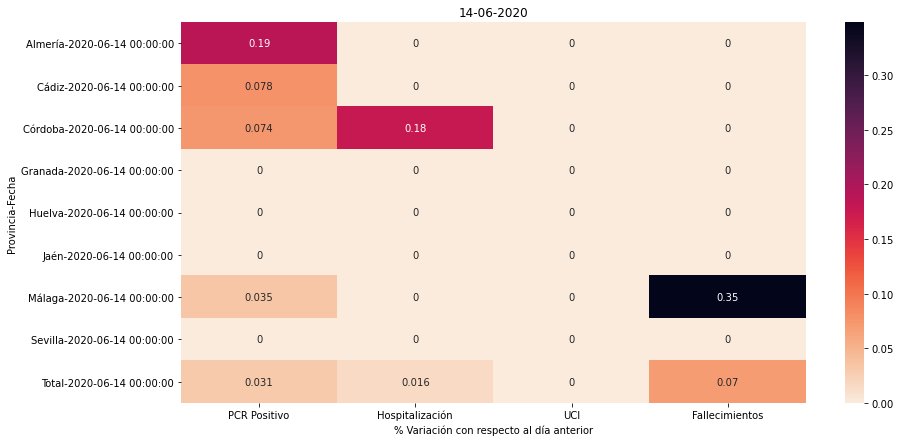

In [12]:
# Set the width and height of the figure
plt.figure(figsize=(14,7))

# Add title
plt.title(last_fecha.strftime('%d-%m-%Y'))

# Invertir los colores
cmap = sns.cm.rocket_r

# Heatmap 
sns.heatmap(data=dfG[['PCR Positivo', 'Hospitalización', 'UCI', 'Fallecimientos']], annot=True, cmap=cmap)

# Add label for horizontal axis
plt.xlabel('% Variación con respecto al día anterior')
plt.show()

In [13]:
provincia = 'Total'
dias = 15
# data = df.loc[provincia][['Hospitalización', 'Curados', 'Fallecimientos']].diff().tail(dias).copy()
data = df.loc[provincia].diff().tail(dias).copy()
titulo = 'Nuevos casos en los últimos ' + str(dias) + ' días en ' + provincia


In [14]:
print(titulo)
print(data)

Nuevos casos en los últimos 15 días en Total
variable    Curados  Fallecimientos  Hospitalización  PCR Positivo  UCI
Fecha                                                                  
2020-05-31     66.0             2.0              1.0           NaN  NaN
2020-06-01     46.0            -1.0              1.0           NaN  NaN
2020-06-02    157.0             1.0              8.0          28.0  0.0
2020-06-03    120.0             0.0              6.0          16.0 -1.0
2020-06-04    106.0             3.0             10.0          16.0  0.0
2020-06-05    114.0             1.0             -1.0          12.0  1.0
2020-06-06    123.0             0.0              4.0          23.0  3.0
2020-06-07     15.0             2.0              2.0           8.0  0.0
2020-06-08     27.0             0.0              0.0          -1.0  0.0
2020-06-09    181.0             3.0              0.0           4.0  0.0
2020-06-10    110.0             0.0              2.0          11.0  1.0
2020-06-11     83.0

Nuevos casos en los últimos 15 días en Total. (Nuevos ingresos hospitalarios)


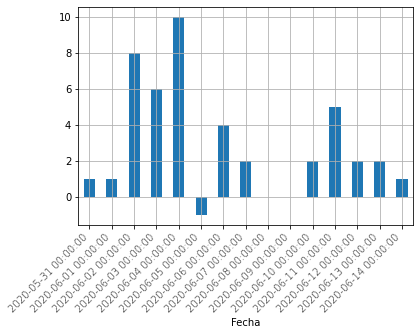

In [15]:
print(titulo + '. (Nuevos ingresos hospitalarios)')
data['Hospitalización'].plot(kind='bar', grid=True)
plt.xticks(
    rotation=45,    
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

In [16]:
# Fecha de último ingreso en hospital
data = df[['Hospitalización']].diff()
data = data[data['Hospitalización'] > 0].sort_index(ascending=False).groupby('Provincia').head(1).copy()
data.reset_index(inplace=True)
data['dias'] = pd.to_datetime(fecha, dayfirst=True) - data['Fecha']
data.set_index('Provincia', inplace=True)
data.sort_values('dias', ascending=False)

variable,Fecha,Hospitalización,dias
Provincia,,,
Jaén,2020-06-03,1.0,11 days
Huelva,2020-06-06,1.0,8 days
Granada,2020-06-11,2.0,3 days
Málaga,2020-06-12,2.0,2 days
Sevilla,2020-06-13,1.0,1 days
Cádiz,2020-06-13,1.0,1 days
Almería,2020-06-13,1.0,1 days
Total,2020-06-14,1.0,0 days
Córdoba,2020-06-14,1.0,0 days
